In [1]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Step 1: Importing dataset

In [2]:
dataset = pd.read_csv("AMZN.csv")
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [3]:
dataset.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
price_close  = dataset[["Close"]].copy()
price_close.index = dataset["Date"]
price_close

,Close
Date,
1997-05-15,0.097917
1997-05-16,0.086458
1997-05-19,0.085417
1997-05-20,0.081771
1997-05-21,0.071354
...,...
2023-03-30,102.000000
2023-03-31,103.290001
2023-04-03,102.410004


In [5]:
def plot_amazon_stock(x_data, y_data, label):
    plt.figure(figsize=(10, 5))
    plt.plot(x_data, y_data, label=f"{label}")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.ylabel("Price")
    plt.title(f"{label}")
    plt.show()


## Step 2: Vizualization

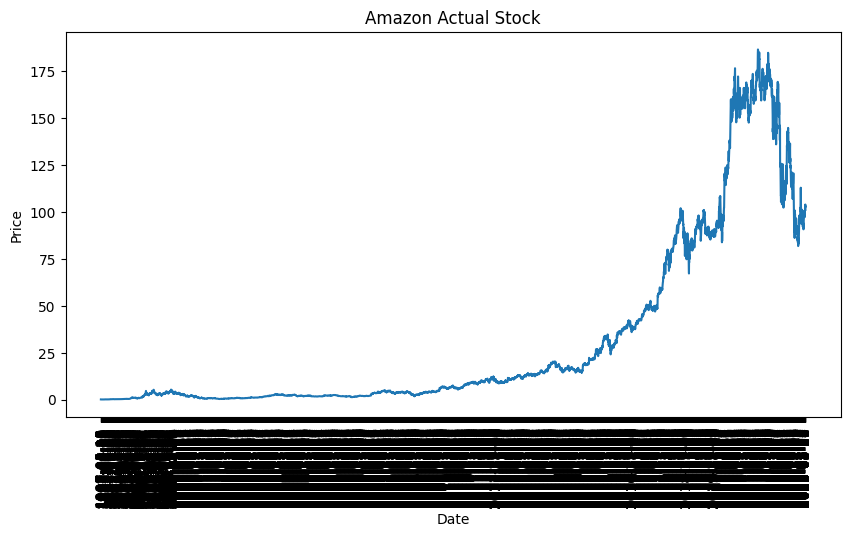

In [6]:
plot_amazon_stock(price_close.index, price_close["Close"], label = "Amazon Actual Stock")


In [7]:
dataset_prices = dataset.copy()
dataset_prices = dataset_prices.set_index("Date")
dataset_prices.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [34]:
def sequencial_dataset(data, windows):
    data_input = []
    data_output = []
    for i in range(windows, len(data)):
        data_input.append(data[i - windows:i])
        data_output.append(data[i, -1])
    return np.array(data_input), np.array(data_output)
        


In [75]:
dataset_prices = dataset[["Open", "High", "Low", "Adj Close", "Volume", "Close"]]
dataset_prices.shape

(6516, 6)

In [36]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scalered_data = scaler.fit_transform(dataset_prices)
scalered_data


array([[-0.99944892, -0.99944211, -0.99966739, -0.99969839,  0.38034321,
        -0.99969839],
       [-0.99969941, -0.9997183 , -0.99978577, -0.99982128, -0.72626105,
        -0.99982128],
       [-0.99981074, -0.99982876, -0.99983087, -0.99983244, -0.89176634,
        -0.99983244],
       ...,
       [ 0.09260795,  0.09467306,  0.09717219,  0.09747802, -0.96976975,
         0.09747802],
       [ 0.09741741,  0.10432402,  0.10453255,  0.11399263, -0.96252143,
         0.11399263],
       [ 0.10981528,  0.1012485 ,  0.08981185,  0.08342975, -0.96594923,
         0.08342975]], shape=(6516, 6))

In [37]:
x_scaled, y_scaled = sequencial_dataset(scalered_data, windows= 4)
x_scaled.shape, y_scaled.shape

((6512, 4, 6), (6512,))

In [38]:
train_split = int(len(x_scaled)*0.8)
train_split
X_train_np, y_train_np = x_scaled[:train_split], y_scaled[:train_split]
X_test_np, y_test_np = x_scaled[train_split:], y_scaled[train_split:]
X_train_np.shape, y_train_np.shape, X_test_np.shape, y_test_np.shape

((5209, 4, 6), (5209,), (1303, 4, 6), (1303,))

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [40]:

X_train, y_train = torch.from_numpy(X_train_np), torch.from_numpy(y_train_np)
X_test, y_test = torch.from_numpy(X_test_np), torch.from_numpy(y_test_np)

In [41]:
type(X_train), X_train.shape

(torch.Tensor, torch.Size([5209, 4, 6]))

In [42]:
class Amazon_ts(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X.float()
        self.y = y.float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] 

In [43]:
train_dataset = Amazon_ts(X_train, y_train)
test_dataset = Amazon_ts(X_test, y_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
class MultivariateLSTM(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden, n_layers):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers,  dropout = 0.2, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_classes)
        self.out_act = nn.Tanh() 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.out_act(out)
        return out 

In [45]:

model = MultivariateLSTM(6, 1, 18, 2)
model.to(device)
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [48]:


epochs = 100

for epoch in range(epochs):
    model.train()
    loss_val = 0
    for _ , batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].unsqueeze(-1).to(device)
        y_pred = model(X_batch)
        loss = loss_fun(y_pred, y_batch)
        loss_val +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_av = loss_val / len(train_loader)
    print(f"{epoch +1}/{epochs} | Loss: {loss_av}")


1/100 | Loss: 4.8321578033433435e-05
2/100 | Loss: 6.0404239948351505e-05
3/100 | Loss: 4.6084158038531224e-05
4/100 | Loss: 5.138172280098536e-05
5/100 | Loss: 4.897406542353386e-05
6/100 | Loss: 5.512793696245487e-05
7/100 | Loss: 4.4544956947628987e-05
8/100 | Loss: 4.314833474655291e-05
9/100 | Loss: 4.73812135080007e-05
10/100 | Loss: 4.4474336497446e-05
11/100 | Loss: 4.7218287876982846e-05
12/100 | Loss: 3.994242322096955e-05
13/100 | Loss: 4.456065179081276e-05
14/100 | Loss: 5.45387885242592e-05
15/100 | Loss: 4.719395016144534e-05
16/100 | Loss: 5.253785371243314e-05
17/100 | Loss: 5.041359435398049e-05
18/100 | Loss: 4.7687273467860566e-05
19/100 | Loss: 3.9922393809732954e-05
20/100 | Loss: 4.397324990048866e-05
21/100 | Loss: 4.442937885194323e-05
22/100 | Loss: 4.592903133574052e-05
23/100 | Loss: 5.3603417481841416e-05
24/100 | Loss: 3.964389326905066e-05
25/100 | Loss: 4.5101876514833466e-05
26/100 | Loss: 4.670009131330327e-05
27/100 | Loss: 4.339784967993026e-05
28/10

In [50]:
torch.save(model.state_dict(), "amazon.pth")

In [52]:
model =  MultivariateLSTM(6, 1, 18, 2)
model.load_state_dict(torch.load("amazon.pth"))
model.to(device)

MultivariateLSTM(
  (lstm): LSTM(6, 18, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=18, out_features=1, bias=True)
  (out_act): Tanh()
)

In [ ]:
model.eval()
y_predicted = []
loss_model = 0
with torch.no_grad():
    for _, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].unsqueeze(-1).to(device)
        print(y_batch.shape) 
        y_pred = model(X_batch)
        print(y_pred.shape) 
        y_predicted.extend(y_pred.cpu().numpy().flatten())

        loss = loss_fun(y_pred, y_batch)
        loss_model +=loss.item()
    avg_loss = loss_model / len(test_loader)
    print(f"Loss: {avg_loss} ")
    print(np.array(y_predicted))

torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


In [ ]:
dummies_predicted = np.zeros(shape=(X_test.shape[0], dataset_prices.shape[1]))
dummies_predicted[:, 0] = np.array(y_predicted)
y_pred= scaler.inverse_transform(dummies_predicted)[:, 0]
y_pred


array([73.68865848, 73.93394585, 74.35173506, ..., 86.5203255 ,
       86.87909021, 87.40518421], shape=(1303,))

In [97]:
dummies_real = np.zeros(shape=(X_test.shape[0], dataset_prices.shape[1]))
dummies_real[:, 0] = np.array(y_test_np)
y_real= scaler.inverse_transform(dummies_real)[:, 0]
y_real[0:]


array([ 69.73467675,  71.73891138,  69.73467675, ..., 102.75567086,
       104.30085754, 101.44124682], shape=(1303,))

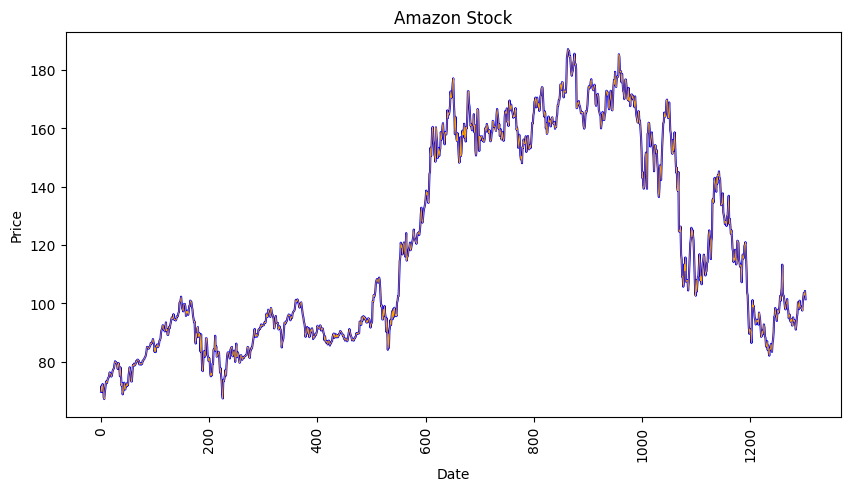

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real Price", color="blue")
plt.plot(y_pred, label="Predicted Price", color="orange", linewidth="0.5")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Price")
plt.title("Amazon Stock")
plt.show()